# Project 5: Credit Card Customer Segmentation

**Background:** AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster.

**Objective:** Using an unsupervised learning approach, identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

**Key Questions:**

1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

We will tackle this project in several parts:

1. [Import the dataset and libraries](#1)
2. [Perform Exploratory Data Analysis](#2)
3. [Execute K-means Clustering](#3)
4. [Execute Hierarchical Clustering](#4)
5. [Calculate Average Silhouette Scores](#5)
6. [Compare K-means Clusters with Hierarchical Clusters](#6)
7. [Address the Key Questions using Cluster Analysis](#7)

<a id="1"></a>
### Step 1: Import the dataset and libraries

In [30]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# configure visualization defaults
plt.style.use('fivethirtyeight')
%matplotlib inline

# ignore warnings
import warnings; warnings.simplefilter('ignore')

# preprocessing helpers
from sklearn.preprocessing import StandardScaler

# cluster models
from sklearn.cluster import KMeans, AgglomerativeClustering

# hierachial clustering helpers
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist


In [2]:
# load the data as pandas dataframe
data = pd.read_excel("Credit Card Customer Data.xlsx")

In [3]:
# verify that the data loaded correctly
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
# get the number of rows and columns of the data
print("There are {} rows and {} columns in the dataset.".format(data.shape[0],data.shape[1]))

There are 660 rows and 7 columns in the dataset.


***Description of Features***

| Name                | Description                                      |
|---------------------|--------------------------------------------------|
|Customer key         | Identifier for the customer                      |
|Average Credit Limit | Average credit limit across all the credit cards |
|Total credit cards   | Total number of credit cards                     |
|Total visits bank    | Total number of bank visits                      |
|Total visits online  | Total number of online visits                    |
|Total calls made     | Total number of calls made by the customer       |


Before we dive into EDA portion of the case study, let's first assemble a data quality report.

In [5]:
def data_report(dataframe):
    
    # create numerical data report using built in describe() method
    data_report = dataframe.describe().T
    
    # add a percent missing column
    data_report['% missing'] = dataframe.apply(lambda x: x.isna().mean())
    
    # add a cardinality column
    data_report['cardinality'] = dataframe.apply(lambda x: x.nunique())
    
    # add a skew column
    data_report['skew'] = dataframe.apply(lambda x: x.skew())
    
    # rearrange the columns 
    cols = ['count','% missing','cardinality','mean','std','min','25%','50%','75%','max','skew']
    data_report = data_report[cols]
    
    return data_report

In [6]:
data_report(data)

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Sl_No,660.0,0.0,660,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0,0.000000
Customer Key,660.0,0.0,655,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0,0.051462
Avg_Credit_Limit,660.0,0.0,110,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0,2.202396
Total_Credit_Cards,660.0,0.0,10,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0,0.144879
Total_visits_bank,660.0,0.0,6,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0,0.141896
Total_visits_online,660.0,0.0,16,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0,2.225607
Total_calls_made,660.0,0.0,11,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0,0.658905


SI_No appears to be an identifier as does Customer Key. There might be duplicate records since the cardinality of Customer Key is 655 and the total number of records is 660.

In [7]:
# checking for duplicates
duplicates = data.duplicated()
data[duplicates].shape[0]

0

Customer Key and SI_No are not informative. We will drop these columns from the data set.

In [8]:
# dropping Sl_No and Customer Key
data.drop(columns=['Sl_No', 'Customer Key'], inplace=True)

<a id="2"></a>
### Step 2: Exploratory Data Analysis
#### 2.1 Univariate Analysis

<b style="color:#2E86C1;font-size:15px;">Avg Credit Limit and Total Credit Cards</b>

In [9]:
data_report(data).loc[['Avg_Credit_Limit','Total_Credit_Cards']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Avg_Credit_Limit,660.0,0.0,110,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0,2.202396
Total_Credit_Cards,660.0,0.0,10,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0,0.144879


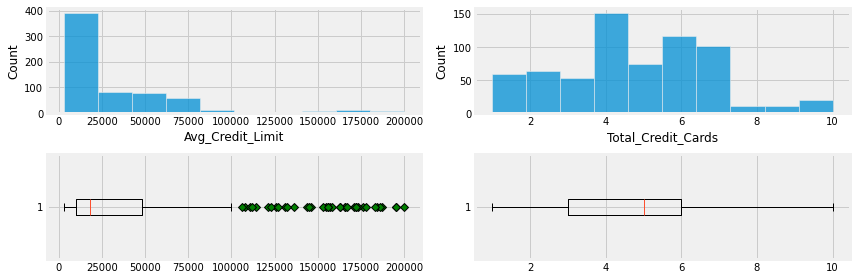

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4), sharex=False)

sns.histplot(data=data, x='Avg_Credit_Limit', bins=10, ax=axes[0,0]);
sns.histplot(data=data, x='Total_Credit_Cards', bins=10, ax=axes[0,1]);
axes[1,0].boxplot(data['Avg_Credit_Limit'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['Total_Credit_Cards'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

**Avg_Credit_Limit** exibits three customer segments. The first, and that which most customers fall into, is those whose average credit limit is between 3k and 20k. Customers who have an average credit limit between 20k and 100k fall into another segement, and finally a third segment which encompasses customers who have an average credit limit above 100k. This last segment contains all of the outliers in this feature. The values for these outliers seem legitimate so we will not be treating them at this time.

**Total_Credit_Cards** is interesting because it exhibits three or even four customer segements:
- customers who have between one and three credit cards,
- customers who have four credit cards,
- customers who have between five and seven credit cards,
- and finally, customers that have more than seven credit cards.

<b style="color:#2E86C1;font-size:15px;">Total Bank and Online Visits</b>

In [11]:
data_report(data).loc[['Total_visits_bank','Total_visits_online']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Total_visits_bank,660.0,0.0,6,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0,0.141896
Total_visits_online,660.0,0.0,16,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0,2.225607


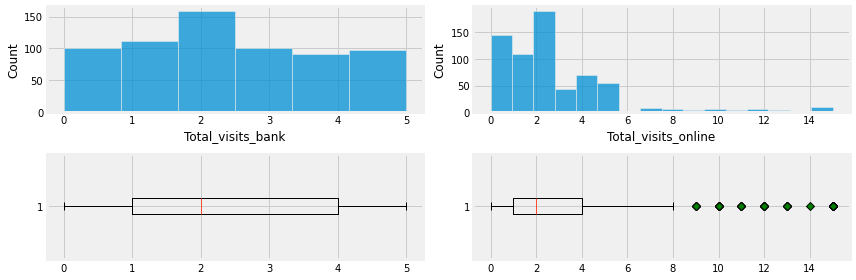

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4), sharex=False)

sns.histplot(data=data, x='Total_visits_bank', bins=6, ax=axes[0,0]);
sns.histplot(data=data, x='Total_visits_online', bins=16, ax=axes[0,1]);
axes[1,0].boxplot(data['Total_visits_bank'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['Total_visits_online'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

**Total_visits_bank** is normally distributed with the majority of customers making two to three trips to the bank. This feature does not provide much information on the segementation of the customer base.

**Total_visits_online** however, we observe perhaps 3 distinct ditributions:
- customers who visited the website between zero and two times,
- customers who visited the website between three and five times,
- and finally, customers who visited more than six times.

This last segment encompasses all of the outliers in this feature, but since these observations all seem valid we will not be treating them at this time.

<b style="color:#2E86C1;font-size:15px;">Total Calls Made</b>

In [13]:
data_report(data).loc[['Total_calls_made']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
Total_calls_made,660.0,0.0,11,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0,0.658905


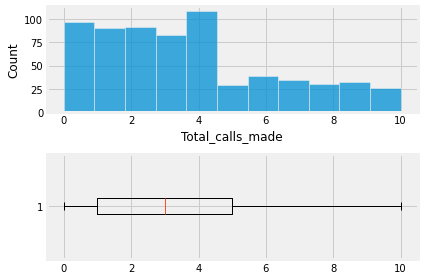

In [14]:
fig, axes = plt.subplots(2, figsize=(6, 4), sharex=False)

sns.histplot(data=data, x='Total_calls_made', bins=11, ax=axes[0]);
axes[1].boxplot(data['Total_calls_made'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));

plt.tight_layout()

**Total_calls_made** we observe two uniform distributions. The first captures those customers who made between zero and four calls to the bank. The second captures those who called more the four times. 

#### 2.1 Bivariate Analysis

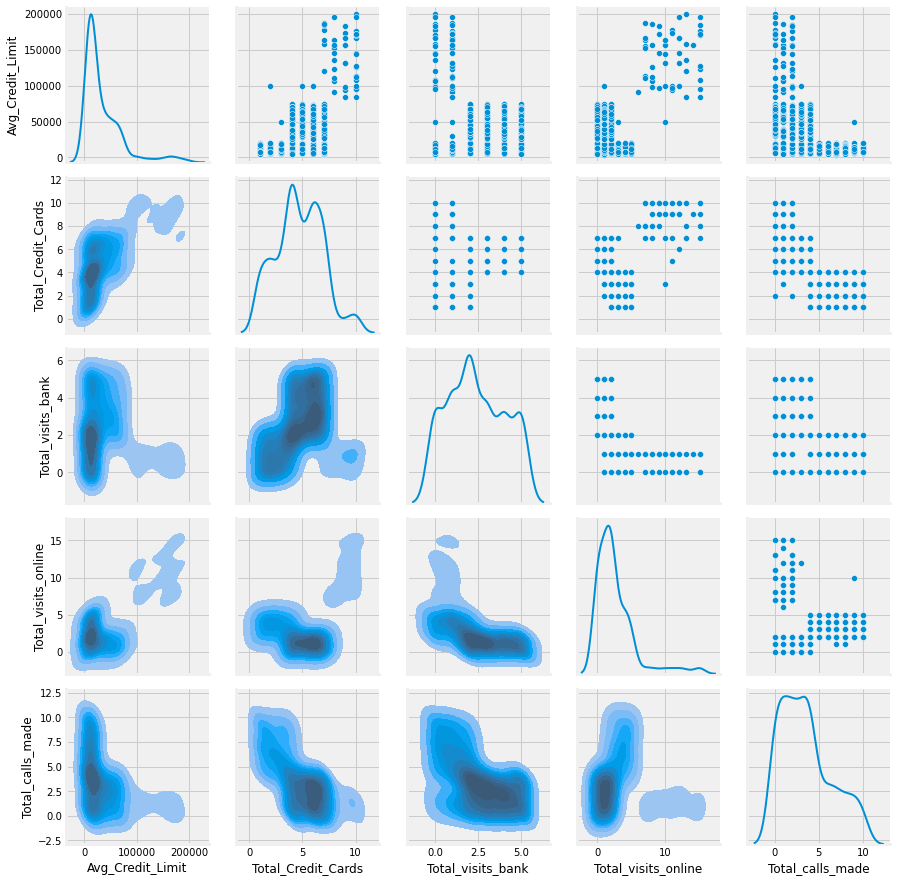

In [15]:
g = sns.PairGrid(data, diag_sharey=False);
g.map_upper(sns.scatterplot);
g.map_lower(sns.kdeplot, fill=True );
g.map_diag(sns.kdeplot,  linewidth=2);

Two to three groups looks appropriate

<a id="3"></a>
### Step 3: K-Means Clustering

#### 3.1 Transform Features using Standard Scaler
The average credit card limit is on a much larger scale than the other features and thus would dominate the clustering analysis. To address this issue we must first scale our data using a z-score transformation. This transform our features to have a mean of zero and a standard deviation of one.

In [16]:
# using standard scaler to transform the features to have mean zero and std of one.
std_scaler =StandardScaler()
X = std_scaler.fit_transform(data)

#### 3.2 Using an Elbow Plot to Identify the Optimal Number of Clusters

One of the obstacles in K-Means clustering is that we have to choose the number of clusters a priori, that is we do not know the correct number of clusters before running the algorithm. Fortunately, we have ways of measuring the effectiveness of the segmentation that is obtained for a given number of clusters. One such measure is the within-cluster **sum of squared errors (SSE)** commonly referred to as **distortion** or **inertia**:

\begin{equation*}
SSE = \sum^n_{i=1}\sum^{k}_{j=1}\,{w}^{(i,j)}\|\mathbf{x}^{(i)}-\mathbf{\mu}^{(j)}\|_{2}^{2},
\end{equation*} 

where $\mathbf{\mu}^{(j)}$ is the centroid for cluster *j*, and $w^{(i,j)}$ is given by


\begin{equation*}
{w}^{(i,j)}=\left\{ \begin{array}{lc}
1, & \mbox{if}\: \mathbf{x}^{(i)} \in j\\
0, & \mbox{otherwise}.
\end{array}\right.
\end{equation*}

Given the nature of K-Means, adding a new cluster will always reduce the distortion. However, past a certain number of clusters the distortion will only decrease by a small amount at which point the algorithm is simply capturing noise in the data and not the actual segmentations. To demonstrate this we use a grapichal method called an elbow plot where we calculate the distortion for a range of different values of *k* and then plot the distortions as a function of *k*. 

In [17]:
# calculate the distortions for ten different values of k (k = 1,...,10)
distortions = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, # number of clusters
                n_init=10, # fit the model 10 different times and return the best one in terms of distortion 
                random_state=1)
    km.fit(X)
    distortions.append(km.inertia_)

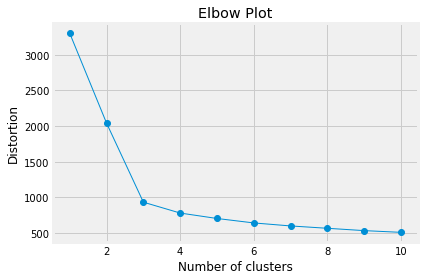

In [18]:
plt.plot(range(1, 11), distortions, marker='o', linewidth=1)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Plot")
plt.tight_layout()
plt.show()

Based on the elbow plot we conclude that three is the ideal number of clusters using K-Means. Next we refit the model using three clusters and analyze the distribution of the features across the different clusters.

In [19]:
# refit the model using three clusters
kmeans = KMeans(n_clusters=3,random_state=1)

# predict cluster labels
km_clusters = kmeans.fit_predict(X)

# add the cluster labels to the original dataframe
data['km_clusters'] = km_clusters

#### 3.3 Boxplots of the Features across the Clusters

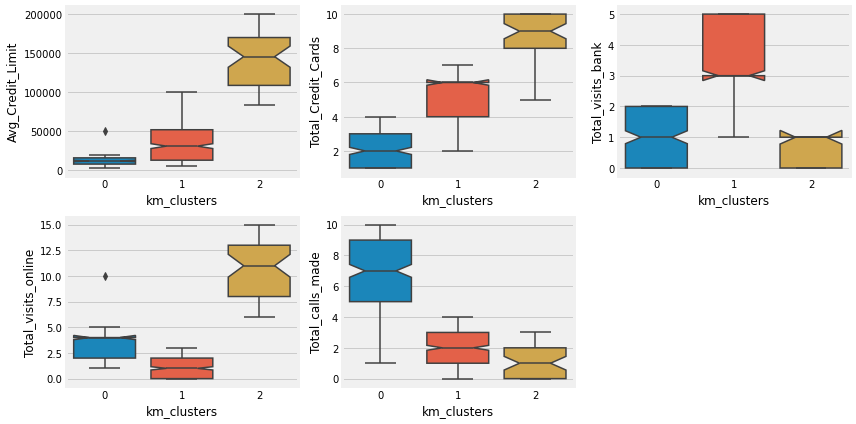

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for idx,feature in enumerate(data.columns[:-1]): 
    ax=axes.flatten()[idx]
    sns.boxplot(data=data, x='km_clusters', y=feature, ax=ax, linewidth=1.5, notch=True);
    
axes[1,2].set_axis_off()
plt.tight_layout()

The K-Means has segmented the data well. We can see a clear separation between the clusters especially for the features Total_Credit_Cards, Total_visits_online, and Avg_Credit_Limit.

<a id="4"></a>
### Step 4: Hierarchial Clustering

In [80]:
methods = ['single','complete', 'average', 'weighted']
metrics = ['chebyshev', 'cityblock', 'correlation','euclidean', 'jaccard', 'mahalanobis']
coph_dists = np.zeros([4,6])

for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        Z = linkage(X, metric=metric, method=method)
        coph, coph_mat = cophenet(Z , pdist(X))
        coph_dists[i,j] = coph

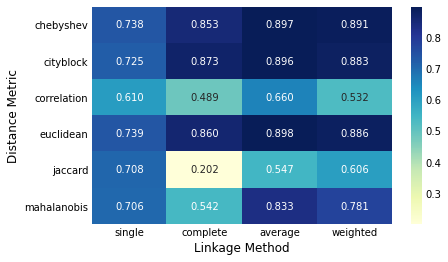

In [107]:
coph_df = pd.DataFrame(coph_dists, index=methods, columns=metrics).T
sns.heatmap(coph_df,annot=True,  fmt=".3f", cmap="YlGnBu");
plt.xlabel("Linkage Method");
plt.ylabel("Distance Metric");

In [44]:
# refit using 'average' as the linkage method and 'euclidean' as the distance metric
Z = linkage(X, metric='euclidean', method='average')

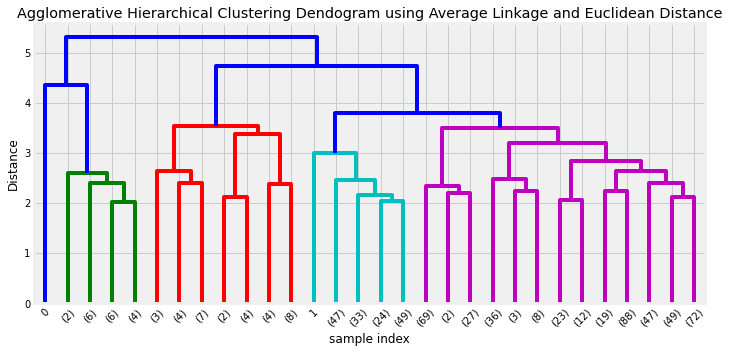

In [117]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram using Average Linkage and Euclidean Distance')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, color_threshold='default', truncate_mode='lastp')
plt.tight_layout()

In [118]:
# create hierachial clustering using 4 clusters with average linkage
ac = AgglomerativeClustering(n_clusters=5, 
                             affinity='euclidean', 
                             linkage='average')

# predict cluster labels
ac_clusters = ac.fit_predict(X)

# add the cluster labels to the original dataframe
data['ac_clusters'] = ac_clusters

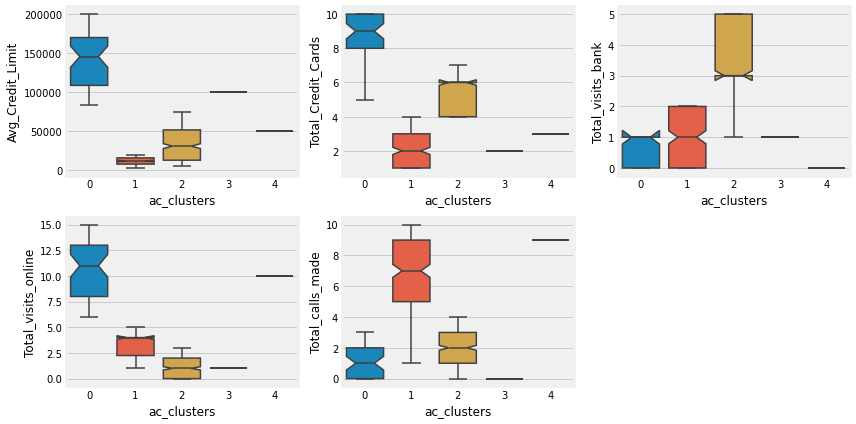

In [119]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for idx,feature in enumerate(data.columns[:5]): 
    ax=axes.flatten()[idx]
    sns.boxplot(data=data, x='ac_clusters', y=feature, ax=ax, linewidth=1.5, notch=True);
    
axes[1,2].set_axis_off()
plt.tight_layout()